In [ ]:
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection as fdr
from tqdm import tqdm

In [ ]:
# Initialize
np.random.seed(42)
PATH = '...'
cat = 'DEL'

# Initialize functions
scaler = StandardScaler()

Load data

In [ ]:
# Load covariates
df_cov = pd.read_csv(PATH + '....csv')
# Load CNV data
df_cnv = pd.read_csv(PATH + '....csv')
# Load PLS results
pls_results = pd.read_csv(PATH + '....csv')
ndim = 3
x_score_ctrl = pls_results.loc[pls_results['SampleID'].isin(df_cov['SampleID']), ['x_score_1', 'x_score_2', 'x_score_3']]
y_score_ctrl = pls_results.loc[pls_results['SampleID'].isin(df_cov['SampleID']), ['y_score_1', 'y_score_2', 'y_score_3']]

# Prepare PLS scores dataframe
df_score = pd.DataFrame(data=np.hstack((x_score_ctrl, y_score_ctrl)),
                        columns=['x_score_1', 'x_score_2', 'x_score_3',
                                 'y_score_1', 'y_score_2', 'y_score_3'],
                        index=df_cov['SampleID'])

df_score.reset_index(inplace=True, drop=False)
df_score.rename(columns={'index': 'SampleID'}, inplace=True)

Annotation of brain scores

Brain expression

In [ ]:
# Effects of expression specificity
gene_lists = ['High', 'Elevated', 'Low', 'Not']
df_exp_high = pd.read_csv(PATH + '.../HPA_brain_high.tsv', sep='\t',
                          usecols=['Ensembl'], dtype=str)
df_exp_med = pd.read_csv(PATH + '.../HPA_brain_elevated.tsv', sep='\t',
                         usecols=['Ensembl'], dtype=str)
df_exp_low = pd.read_csv(PATH + '.../HPA_brain_low.tsv', sep='\t',
                         usecols=['Ensembl'], dtype=str)

In [ ]:
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    # Number of highly or elevated genes in brain
    sub_idx.append(np.sum(pd.Series(literal_eval(genes)).isin(df_exp_high.Ensembl).values) + \
                   np.sum(pd.Series(literal_eval(genes)).isin(df_exp_med.Ensembl).values))
df_score['brain_exp'] = sub_idx

100%|██████████| 618/618 [00:00<00:00, 4592.71it/s]


Temporal trajectory

In [ ]:
# Effects of temporal specificity
df_list = pd.read_excel(PATH + '..../gene_lists.xlsx', sheet_name='ExpressedGenes_23782',
                        usecols=['EnsemblID', 'Trajectory_group'], dtype=str)
df_list['Trajectory_group'] = df_list['Trajectory_group'].replace({'Rising': 1,
                                                                   'Non-transitional': 0,
                                                                   'Falling': -1,
                                                                   'Other': np.nan})

In [ ]:
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    # Take the earliest expression across all genes within a CNV
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].Trajectory_group.values
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
    # Take average expression
    sub_idx.append(np.mean(tmp))
df_score['temporal_exp'] = sub_idx

Peak epoch

In [ ]:
# Effects of peak epoch
df_list = pd.read_excel(PATH + '.../gene_lists.xlsx', sheet_name='ExpressedGenes_23782',
                        usecols=['EnsemblID', 'PeakEpoch'], dtype=str)
df_list['PeakEpoch'] = df_list['PeakEpoch'].replace({'Other': np.nan})

In [ ]:
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].PeakEpoch.values
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
    # Take average expression
    sub_idx.append(np.mean(pd.Series(tmp).values.astype(int)))
df_score['peak_epoch'] = sub_idx

Disease association

In [ ]:
# Effects of disease associted genes
# Is gene associated with a trait or disorder by either rare or common variation? 0=no, 1=yes
df_list = pd.read_excel(PATH + '.../gene_lists.xlsx', sheet_name='GencodeV21Genes_60155',
                        usecols=['EnsemblID', 'TraitDisorderGene'], dtype=str)
df_list['GwasGene'] = df_list['TraitDisorderGene'].replace({'No': 0, 'Yes': 1})


In [ ]:
# Sum of disease associated genes
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].GwasGene.values.astype(int)
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
        else:
            tmp.append(0)
    tmp = np.sum(tmp)*1
    sub_idx.append(tmp)
df_score['disease'] = sub_idx

100%|██████████| 618/618 [00:03<00:00, 170.95it/s]


pLI

In [ ]:
# Effects of pLI
# Probability of loss-of-function intolerance score for the gene
df_list = pd.read_excel(PATH + '.../gene_lists.xlsx', sheet_name='ExpressedGenes_23782',
                        usecols=['EnsemblID', 'pLI'], dtype=str)

In [ ]:
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].pLI.values.astype(float)
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
        else:
            tmp.append(0)
    tmp = np.nansum(tmp)*1
    sub_idx.append(tmp)
df_score['pLI'] = sub_idx

100%|██████████| 618/618 [00:01<00:00, 392.96it/s]


ASD association

In [ ]:
# Effects of ASD associted genes
# Is ASD (autism spectrum disorder) risk gene from Satterstrom et al 2018, 0=no, 1=yes
df_list = pd.read_excel(PATH + '.../gene_lists.xlsx', sheet_name='GencodeV21Genes_60155',
                        usecols=['EnsemblID', 'RiskGene_ASD'], dtype=str)
df_list['RiskGene_ASD'] = df_list['RiskGene_ASD'].replace({'No': 0, 'Yes': 1})

In [ ]:
# Sum of ASD associated genes
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].RiskGene_ASD.values.astype(float)
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
        else:
            tmp.append(0)
    tmp = np.sum(tmp)*1
    sub_idx.append(tmp)
df_score['ASD'] = sub_idx

100%|██████████| 618/618 [00:03<00:00, 165.05it/s]


SCZ association

In [ ]:
# Effects of SCZ associted genes
# Is SCZ (schizophrenia) risk gene from Schizophrenia Working Group of the Psychiatric Genomics Consortium 2014, 0=no, 1=yes
df_list = pd.read_excel(PATH + '.../gene_lists.xlsx', sheet_name='GencodeV21Genes_60155',
                        usecols=['EnsemblID', 'RiskGene_SCZ'], dtype=str)
df_list['RiskGene_SCZ'] = df_list['RiskGene_SCZ'].replace({'No': 0, 'Yes': 1})

In [ ]:
# Sum of SCZ associated genes
sub_idx = []
for genes in tqdm(df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].gene_id):
    tmp = []
    for gene in literal_eval(genes):
        tmp1 = df_list[df_list.EnsemblID == gene].RiskGene_SCZ.values.astype(float)
        if len(tmp1) > 0:
            tmp.append(tmp1[0])
        else:
            tmp.append(0)
    tmp = np.sum(tmp)*1
    sub_idx.append(tmp)
df_score['SCZ'] = sub_idx

100%|██████████| 618/618 [00:03<00:00, 164.67it/s]


LOEUF

In [ ]:
df_score['sum_loeuf_inv'] = df_cnv[df_cnv.TYPE.isin([cat, 'BOTH'])].sum_loeuf_inv.values

Plot results

In [ ]:
# Correlate PLS scores with covariates
df1 = df_score.loc[:, ['y_score_1', 'y_score_2', 'y_score_3']]
df2 = df_score.loc[:, ['sum_loeuf_inv', 'brain_exp', 'temporal_exp', 'peak_epoch',
                       'ASD', 'SCZ', 'disease']]

# Cross-correlate two dataframes
df_corr = pd.DataFrame(index=df1.columns, columns=df2.columns)
df_pval = pd.DataFrame(index=df1.columns, columns=df2.columns)
for col1 in df1.columns:
    for col2 in df2.columns:
        idx1 = df1[col1].notnull()
        idx2 = df2[col2].notnull()
        idx = idx1 & idx2
        df_corr.loc[col1, col2],  p = pearsonr(df1[col1].values[idx],
                                               df2[col2].values[idx])
        df_pval.loc[col1, col2] = p

# FDR correction
df_pval[:] = np.reshape(fdr(np.reshape(df_pval.values, -1), alpha=0.05)[1], df_pval.shape)

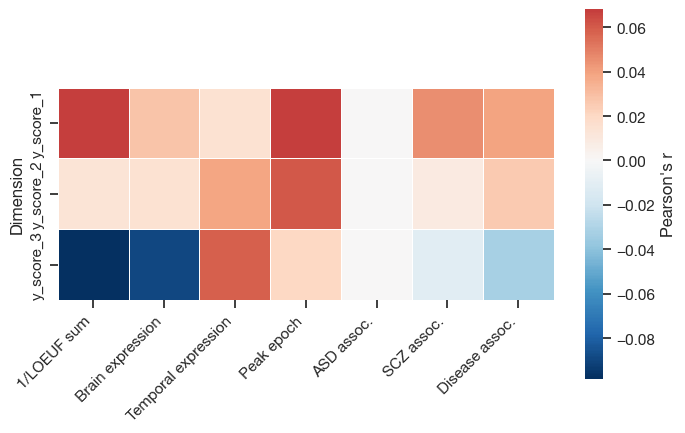

In [ ]:
# Correlation of scores with CNV properties
fig, ax = plt.subplots(1, figsize=(8, 8))
g = sns.heatmap(df_corr.astype(float), center=0, annot=False, fmt='.2f',
                cbar=True, cmap='RdBu_r', cbar_kws=dict(label="Pearson's r", shrink=0.6),
                square=True, linewidths=.5, ax=ax)
ax.set_xticklabels(['1/LOEUF sum', 'Brain expression',
                    'Temporal expression', 'Peak epoch', 
                    'ASD assoc.', 'SCZ assoc.', 'Disease assoc.'],
                    rotation=45, ha='right')
ax.set_ylabel('Dimension')
ax.set_xlabel('')
ax.set_title('')
plt.show()

Cross-correlate CNV annotations

In [ ]:
R = df_score.iloc[:, 7:].astype(float).corr(method='pearson')  # correlation matrix of annotaions
order = ['sum_loeuf_inv', 'brain_exp', 'temporal_exp', 'peak_epoch',
         'ASD', 'SCZ', 'disease']
R = R.loc[order, order]  # reorder the correlation matrix
R[R.isna()] = 0  # set NaN to 0

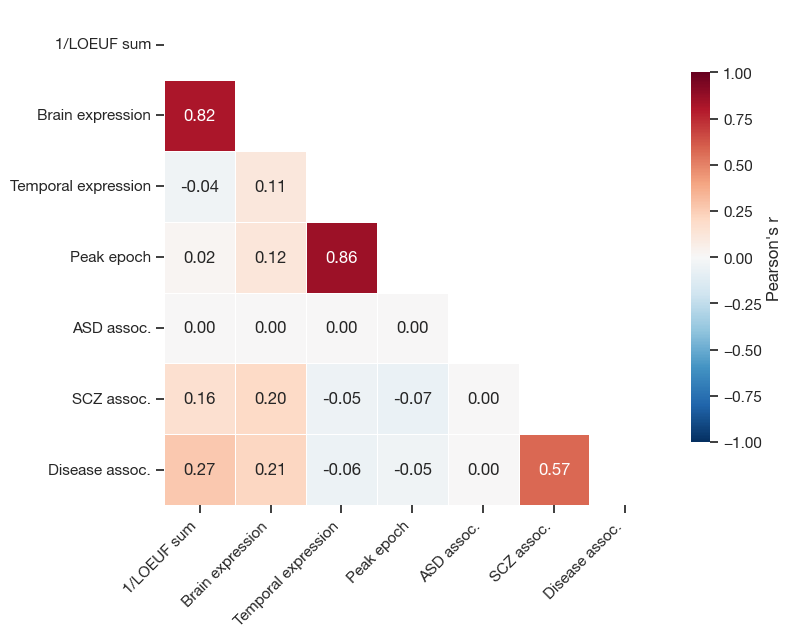

In [ ]:
# Correlation of scores with CNV properties
fig, ax = plt.subplots(1, figsize=(8, 8))
g = sns.heatmap(R, center=0, annot=True, fmt='.2f', vmin=-1, vmax=1,
                cbar=True, cmap='RdBu_r', cbar_kws=dict(label="Pearson's r", shrink=0.6),
                square=True, linewidths=.5, ax=ax)
ax.set_xticklabels(['1/LOEUF sum', 'Brain expression', 'Temporal expression', 'Peak epoch', 
                    'ASD assoc.', 'SCZ assoc.', 'Disease assoc.'],
                    rotation=45, ha='right')
ax.set_yticklabels(['1/LOEUF sum', 'Brain expression', 'Temporal expression', 'Peak epoch', 
                    'ASD assoc.', 'SCZ assoc.', 'Disease assoc.'],
                    rotation=0,)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')
plt.show()